### This script calculates correlations using Spearman rank correlation between observation and models and then plots as heatmap with hatches of Pvalues

### By: Kwesi A. Quagraine (2019)                                                   


In [3]:
import sys

#For working with arrays: NumPy and Pandas
import numpy as np
import pandas as pd

# For loading netCDF data
from netCDF4 import Dataset
import xarray as xr 


# For calculating linear regression
import scipy.stats

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 200
plt.rcParams['hatch.linewidth'] = 0.1

# Datetime libraries for converting dates
from datetime import datetime, timedelta 

# for creating maps
from mpl_toolkits.basemap import Basemap

# Plots in iPython Notebook, not a pop-up window
%matplotlib inline
#%matplotlib notebook

#high resolution plots
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore")




In [4]:
#define file path
anom_path = '/home/kwesi/terra/research/paper2/temp/' 

#create a function to do the analysis;loading the data and perform Spearman rank correlation
def mod_corr(obs,model):
    nc=Dataset(obs,'r')
    obs_var = nc.variables['anom'][:]
    obs = obs_var.ravel()
    
    nc2=Dataset(model,'r')
    model_var=nc2.variables['anom'][:]
    model = model_var.ravel()
    
    #perform Mann-Kendall as a measure of correlation
    #trend = scipy.stats.mstats.theilslopes(obs_var,model_var,0.95)
    corr,pval = scipy.stats.spearmanr(obs,model)
    return(corr,pval)



In [5]:
#create a dictionary for the models
datamod = {1: 'CanESM2', 2: 'CNRM-CM5', 3: 'GFDL-ESM2M', 4: 'HadGEM2-ES', 
             5: 'IPSL-CM5A-LR', 6: 'MIROC-ESM', 7:'MPI-ESM-LR', 8: 'MRI-CGCM3'}

#create a dictionary for the different cobehavior states
num = {1: '1', 2: '2', 3: '7', 4: '8', 5: '5', 6: '6', 7: '3', 8: '4'}

#iterate through files and perform Mann-Kendall test and append to list
modcorrs=[]
for i in datamod:
    for j in num:
        res=mod_corr(anom_path + 'tas_Amon_CRU_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.mask.nc',
                 anom_path + 'tas_Amon_' + datamod[i] + '_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.mask.nc')
        modcorrs=modcorrs+[res]
        
            

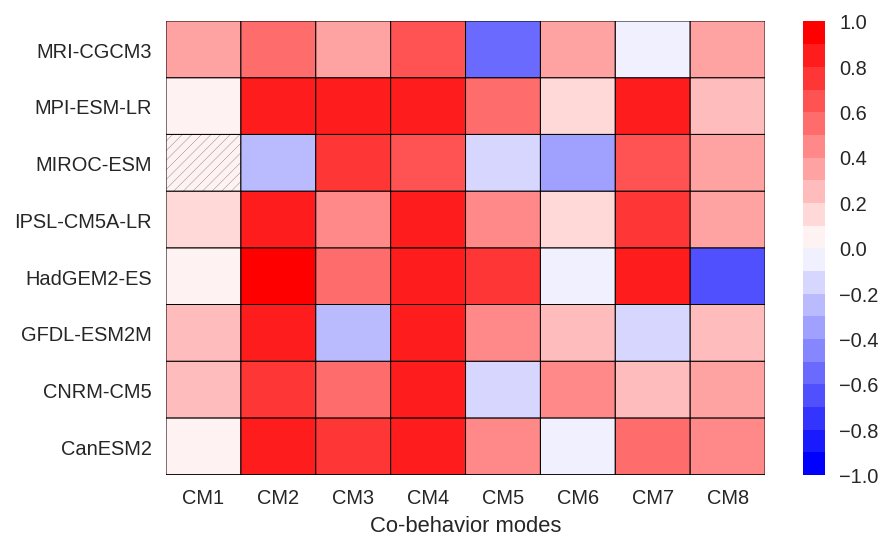

In [9]:
plt.style.use('seaborn')
#unpack stored variable from kendalltau heatmap plot
#%store -r pval_t

#reshape data to 8*8*2 variables and dataframe each variable
modcorrsout = np.array(modcorrs).reshape(8,8,2)

#extract correlation and pvalue dataframes
DF_correlation = pd.DataFrame(modcorrsout[:,:,0])
DF_pvalue = pd.DataFrame(modcorrsout[:,:,1])


#make a dictionary to force plot in a strict order...'sorted' failed to do that huh!
headers_x = {1:'CM1',2:'CM2',3:'CM3',4:'CM4',5:'CM5',6:'CM6',7:'CM7',8:'CM8'}

xlist =[]
for key, value in headers_x.items():
    xlist.append(value)
    
headers_y = {1: 'CanESM2', 2: 'CNRM-CM5', 3: 'GFDL-ESM2M', 4: 'HadGEM2-ES', 
             5: 'IPSL-CM5A-LR', 6: 'MIROC-ESM', 7:'MPI-ESM-LR', 8: 'MRI-CGCM3'}

ylist =[]
for key, value in headers_y.items():
    ylist.append(value)


#now lets make the plot :-) and center the ticks on axis to label them
fig, ax = plt.subplots(figsize=(8,5))
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

mmin = -1
mmax = 1

bounds = np.linspace(-1, 1, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

heatmap = ax.pcolor(DF_correlation,edgecolors='k',norm=norm,cmap = 'bwr',vmin=mmin,vmax=mmax, linewidth=0.5) #norm=norm,grayify_cmap('bwr')
pval_t = np.ma.masked_where(DF_pvalue<0.05,DF_pvalue)
plt.pcolor(pval_t, hatch='/////',cmap = 'bwr', linewidth=2.,alpha=-0.)
cbar = plt.colorbar(heatmap,ticks=np.arange(-1,1.2,0.2))  #,ticks=np.arange(-0.4,0.5,0.1),extend='both'
#cbar.set_label('[deg.C season$\mathregular{^-}{^1}$]')

# Loop over data dimensions and create text annotations
#data = np.array(pval)
#data_rav = data.ravel()
#for y in range(data.shape[0]):
#    for x in range(data.shape[1]):
#        if data_rav[0] < 0.05:
#            plt.plot(pval + 0.5, pval + 0.5, marker='o', markersize=4, color="k")
#        plt.text(x + 0.5, y + 0.5, '%.3f' % data[y, x],
#                 horizontalalignment='center',
#                 verticalalignment='center')


# Loop over data dimensions and create text annotations
#data = np.array(DF_medslope)
#for y in range(data.shape[0]):
#    for x in range(data.shape[1]):
#        plt.text(x + 0.5, y + 0.5, '%.3f' % data[y, x],
#                 horizontalalignment='center',
#                 verticalalignment='center')
        
# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(DF_correlation.shape[0]) + 0.5, minor=False)

# Rotate the xlabels. Set both x and y labels to headers[0:]
ax.set_xticklabels(xlist[0:]) #,rotation=90
ax.set_yticklabels(ylist[0:])
ax.set_xlabel('Co-behavior modes')

#saving plot
#plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_temp_heatmap_ntsig_spearman_v1.png',bbox_inches='tight', dpi = 600)
plt.show()

In [10]:
#plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_temp_heatmap_ntsig_spearman_v1.png',bbox_inches='tight', dpi = 600)